In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import seaborn as sns
import yfinance as yf
import re
from tqdm.notebook import tqdm
from transformers import pipeline
from datasets import Dataset
import ast
from matplotlib.ticker import MaxNLocator
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random
from PIL import Image

plt.style.use('seaborn-v0_8-pastel')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/yeuf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yeuf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yeuf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
df = pd.read_csv('Twitter Jan Mar.csv')

In [3]:
df.head()

date                   id   
0  2023-03-29 22:58:21+00:00  1641213230730051584  \
1  2023-03-29 22:58:18+00:00  1641213218520481805   
2  2023-03-29 22:57:53+00:00  1641213115684536323   
3  2023-03-29 22:57:52+00:00  1641213110915571715   
4  2023-03-29 22:57:26+00:00  1641213003260633088   

                                             content        username   
0  Free AI marketing and automation tools, strate...  RealProfitPros  \
1           @MecoleHardman4 Chat GPT says it’s 15. 😂    AmyLouWho321   
2  https://t.co/FjJSprt0te - Chat with any PDF!\n...      yjleon1976   
3  AI muses: "In the court of life, we must all f...  ChatGPT_Thinks   
4  Most people haven't heard of Chat GPT yet.\nFi...   nikocosmonaut   

   like_count  retweet_count  
0         0.0            0.0  
1         0.0            0.0  
2         0.0            0.0  
3         0.0            0.0  
4         0.0            0.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500036 entries, 0 to 500035
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           500036 non-null  object 
 1   id             500030 non-null  object 
 2   content        500030 non-null  object 
 3   username       500002 non-null  object 
 4   like_count     499974 non-null  float64
 5   retweet_count  499974 non-null  float64
dtypes: float64(2), object(4)
memory usage: 22.9+ MB


In [66]:
df['date'] =  pd.to_datetime(df['date'], errors='coerce')
df['date'] = df['date'].dt.date
df = df.dropna(subset=['date'])
df['date'] = df['date'].astype(str)

In [67]:
def pre_process(text):
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

# Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

# Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

# Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

In [68]:
df['processed_content'] = df['content'].apply(pre_process)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500002 entries, 0 to 500035
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               500002 non-null  object 
 1   id                 500002 non-null  object 
 2   content            500002 non-null  object 
 3   username           499974 non-null  object 
 4   like_count         499974 non-null  float64
 5   retweet_count      499974 non-null  float64
 6   processed_content  500002 non-null  object 
dtypes: float64(2), object(5)
memory usage: 30.5+ MB


In [71]:
df.tail()

date                   id   
500031  2023-01-04  1610536038094757888  \
500032  2023-01-04  1610535961670172674   
500033  2023-01-04  1610535837363486720   
500034  2023-01-04  1610535786017091584   
500035  2023-01-04  1610535734758219778   

                                                  content        username   
500031  @GoogleAI #LAMDA Versus @OpenAI #ChatGPT ?! Wh...      Pup_In_Cup  \
500032  #ChatGPT \n\nSo much #Censorship.\n\nNever tru...  TryingToOffend   
500033  all my twitter feed is about ChatGPT and @Open...          mcp350   
500034  I'm quite amazed by Chat GPT. A really promisi...   manumurali369   
500035  I used chat gpt to get gym workout program and...          pnik91   

        like_count  retweet_count   
500031         1.0            0.0  \
500032         2.0            0.0   
500033         3.0            1.0   
500034         1.0            0.0   
500035         0.0            0.0   

                                        processed_content  
500031   versus who cares lamda isnt available chatgpt...  
500032       so much never trust a system you dont admin   
500033    all my twitter feed is about chatgpt and lol 😆   
500034  im quite amazed by chat gpt a really promising...  
500035  i used chat gpt to get gym workout program and...

In [73]:
january_df = df.loc[df['date'] <= '2023-01-31']
data_column = january_df[['id', 'processed_content']]
df_data = data_column.copy()
dataset = Dataset.from_pandas(df_data)

In [76]:
results = {}
model = pipeline(model='cardiffnlp/twitter-roberta-base-sentiment-latest', device=0, batch_size=32)
for row in tqdm(dataset):
    text = row['processed_content']
    id = row['id']
    results[id] = model(text)

Downloading:   0%|          | 0.00/2.77k [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/135993 [00:00<?, ?it/s]

/home/yeuf/miniconda3/envs/nlp_chatGPT/lib/python3.8/site-packages/transformers/pipelines/base.py:1036: UserWarning:

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



In [101]:
df_results = pd.DataFrame(results).T
df_results = df_results.reset_index().rename(columns={'index': 'id'})
df_results = df_results.rename(columns={0: 'scores'})
df_results['scores'] = df_results['scores'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_results = pd.concat([df_results.drop(['scores'], axis=1), df_results['scores'].apply(pd.Series)], axis=1)
df_results = df_results.merge(january_df, how='left')

In [104]:
# roberta_sentiments.to_csv('Inference_results.csv')

In [2]:
# df_results = pd.read_csv('Inference_results.csv')

In [106]:
df_results['date'] = pd.to_datetime(df_results['date'])
df_results['month'] = df_results['date'].dt.month
df_results['day'] = df_results['date'].dt.day

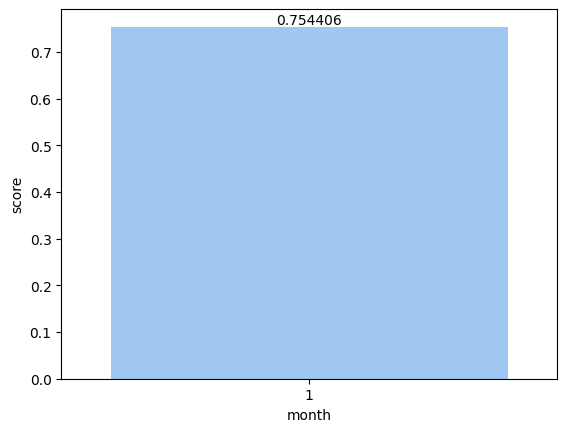

In [107]:
monthly_sentiment = df_results.groupby('month')['score'].mean().reset_index()

# create bar chart
ax = sns.barplot(data=monthly_sentiment, x='month', y='score')
for i in ax.containers:
    ax.bar_label(i)
plt.show()

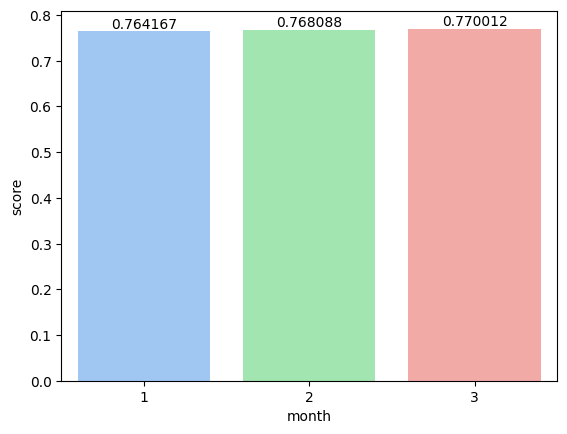

In [63]:
monthly_sentiment = df_results.groupby('month')['score'].mean().reset_index()

# create bar chart
ax = sns.barplot(data=monthly_sentiment, x='month', y='score')
for i in ax.containers:
    ax.bar_label(i)
plt.show()

In [113]:
def get_most_common_words(tweets):
    # concatenate all tweet content
    all_content = ' '.join(tweets['processed_content'])
    # remove punctuation
    # all_content = all_content.translate(str.maketrans('', '', string.punctuation))
    # tokenize the text
    tokens = word_tokenize(all_content)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # get frequency distribution
    fdist = FreqDist(tokens)
    # return the 10 most common words
    return fdist.most_common(10)

In [114]:
positive_tweets = df_results[df_results['label'] == 'positive']
negative_tweets = df_results[df_results['label'] == 'negative']

positive_most_common_words = get_most_common_words(positive_tweets)
negative_most_common_words = get_most_common_words(negative_tweets)

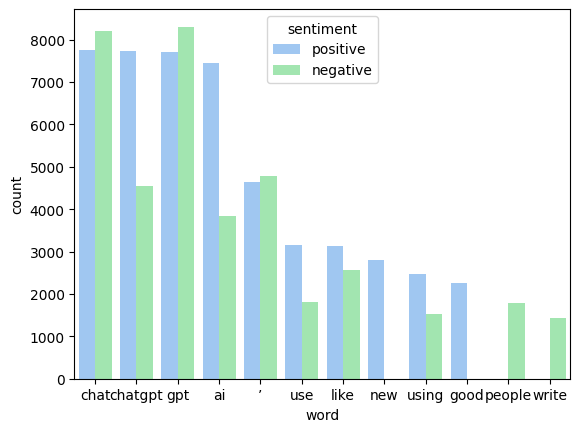

In [115]:
positive_df = pd.DataFrame(positive_most_common_words, columns=['word', 'count'])
positive_df['sentiment'] = 'positive'

# create a dataframe for negative words
negative_df = pd.DataFrame(negative_most_common_words, columns=['word', 'count'])
negative_df['sentiment'] = 'negative'

# concatenate the dataframes
plot_df = pd.concat([positive_df, negative_df])

# create the bar chart
sns.barplot(data=plot_df, x='word', y='count', hue='sentiment')
plt.show()

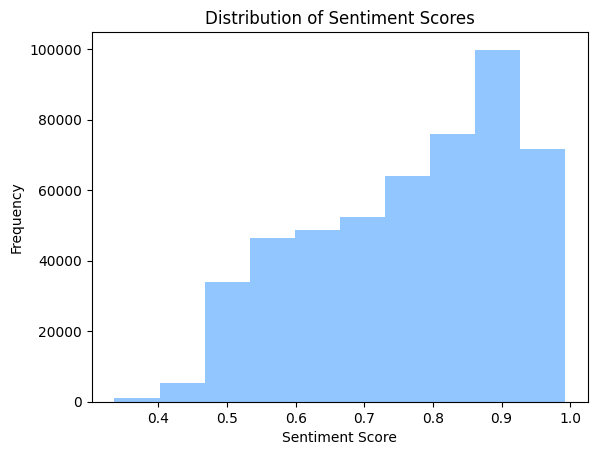

In [58]:
plt.hist(df_results['score'], bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

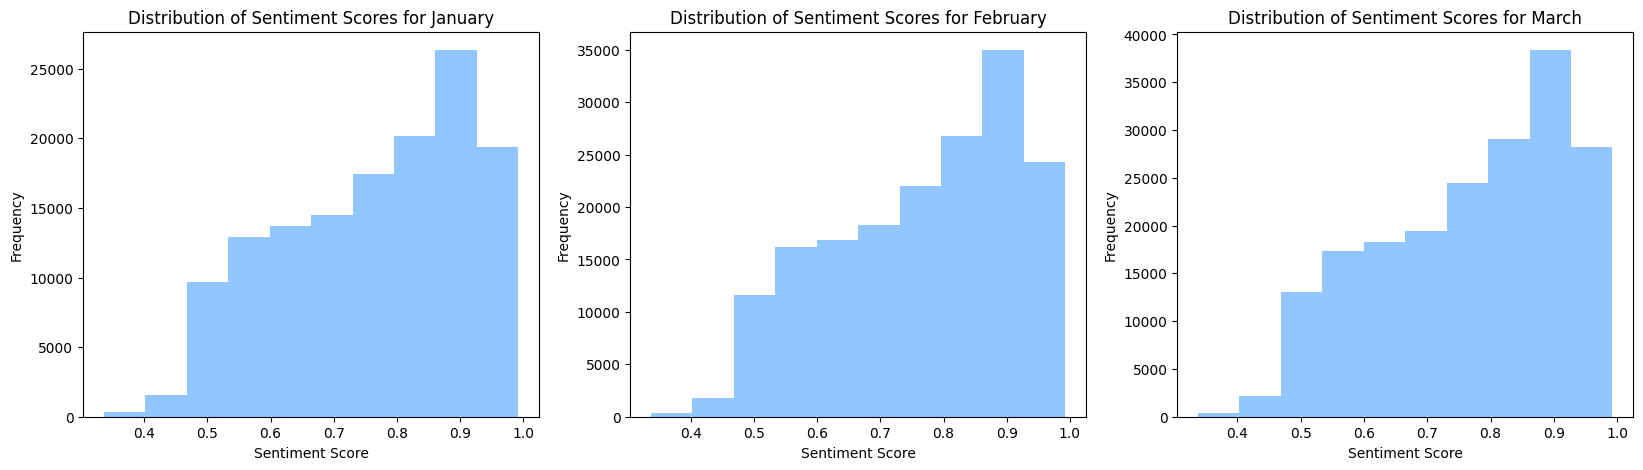

In [19]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))
months = ['January', 'February', 'March']
for i in range(3):
    month_data = df_results[df_results['month'] == i+1]
    axs[i].hist(month_data['score'], bins=10)
    axs[i].set_xlabel('Sentiment Score')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Distribution of Sentiment Scores for {months[i]}')
plt.show()

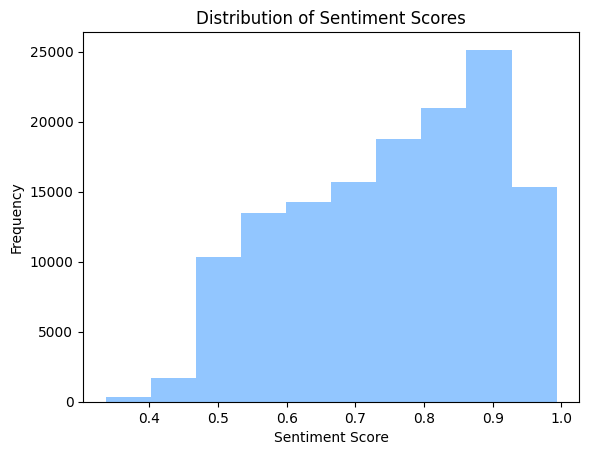

In [109]:
plt.hist(df_results['score'], bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

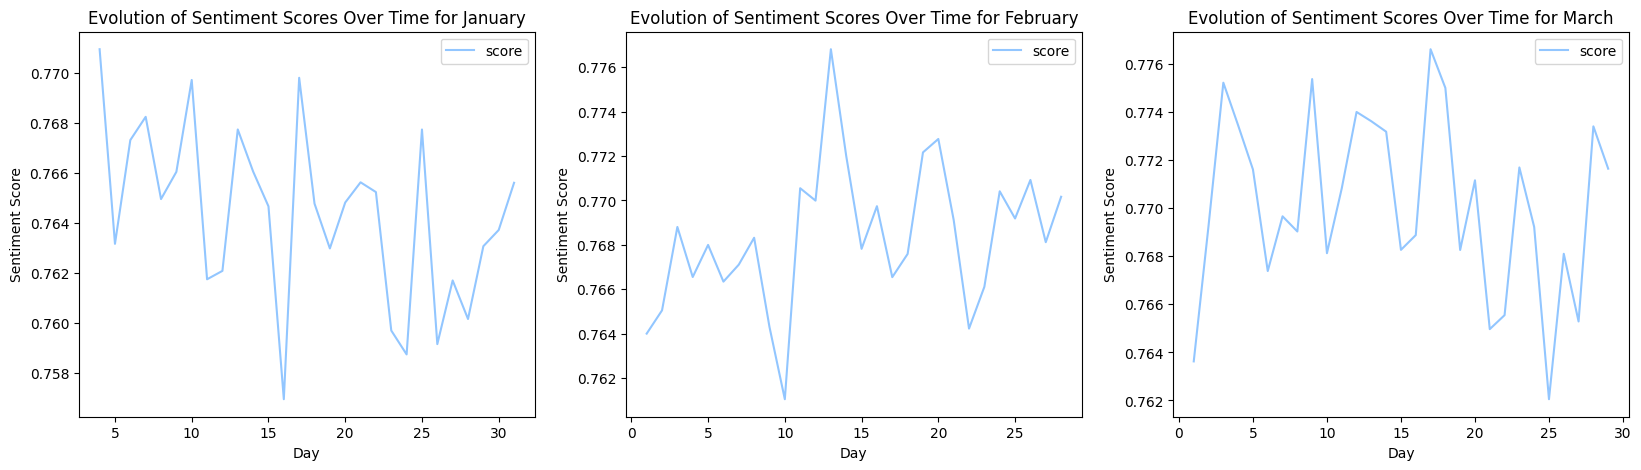

In [20]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))
for i in range(3):
    month_data = df_results[df_results['month'] == i+1]
    pivot = pd.pivot_table(month_data, values='score', index='day')
    pivot.plot(ax=axs[i])
    axs[i].set_xlabel('Day')
    axs[i].set_ylabel('Sentiment Score')
    axs[i].set_title(f'Evolution of Sentiment Scores Over Time for {months[i]}')
plt.show()


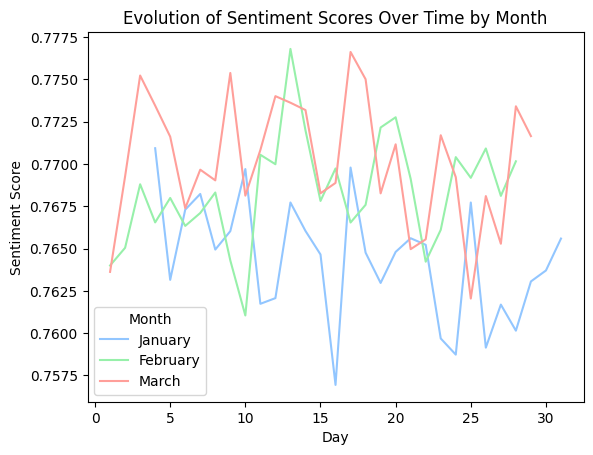

In [23]:
# create a pivot table with the average sentiment score for each day of each month
pivot = pd.pivot_table(df_results, values='score', index='day', columns='month')

# plot the result as a line chart
pivot.plot()
plt.xlabel('Day')
plt.ylabel('Sentiment Score')
plt.title('Evolution of Sentiment Scores Over Time by Month')
plt.legend(['January', 'February', 'March'], title='Month')
plt.show()

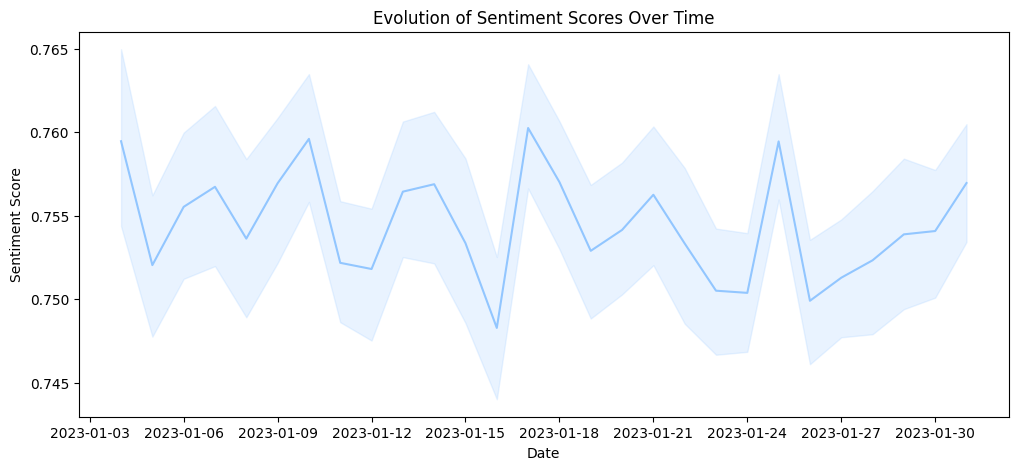

In [110]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(data=df_results, x='date', y='score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Evolution of Sentiment Scores Over Time')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [29]:
tweets_by_day = df_results.groupby(pd.Grouper(key='date', freq='D')).size().reset_index()
tweets_by_day.columns = ['date', 'count']
fig2 = px.bar(tweets_by_day, x='date', y='count', title='Number of Tweets per Day', color = 'count', height=800, width=1300)
fig2.update_xaxes(tickangle=45, tickformat='%Y-%m-%d')
fig2.show()

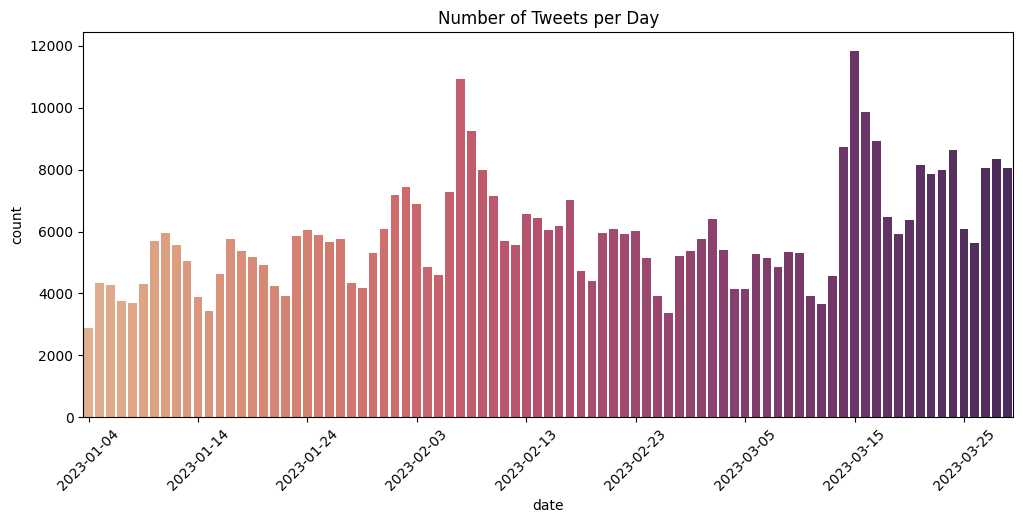

In [32]:
tweets_by_day['date'] = pd.to_datetime(tweets_by_day['date']).dt.date
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(data=tweets_by_day, x='date', y='count', palette='flare')
plt.title('Number of Tweets per Day')
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [6]:
tweets_by_week = df_results.groupby(pd.Grouper(key='date', freq='W')).size().reset_index()
tweets_by_week.columns = ['date', 'count']
fig2 = px.bar(tweets_by_week, x='date', y='count', title='Number of Tweets per Week', color = 'count', height=800, width=1300)
fig2.update_xaxes(tickangle=45, tickformat='%Y-%m-%d')
fig2.show()

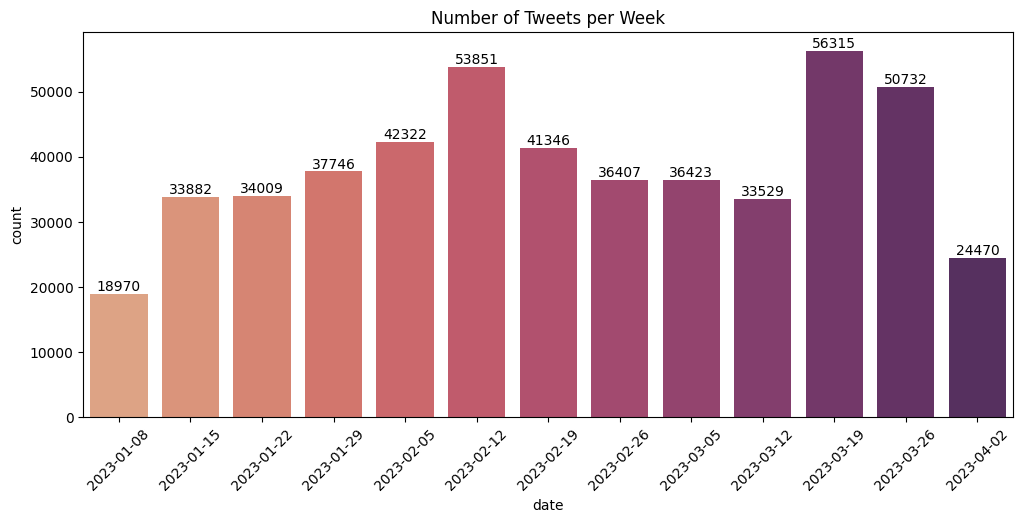

In [30]:
tweets_by_week['date'] = pd.to_datetime(tweets_by_week['date']).dt.date
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(data=tweets_by_week, x='date', y='count', palette='flare')
plt.title('Number of Tweets per Week')
plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i)
plt.show()

In [8]:
tweets_by_month = df_results.groupby(pd.Grouper(key='date', freq='M')).size().reset_index()
tweets_by_month.columns = ['date', 'count']
fig2 = px.bar(tweets_by_month, x='date', y='count', title='Number of Tweets per Month', color = 'count', height=800, width=1300)
fig2.update_xaxes(tickangle=45, tickformat='%Y-%m-%d')
fig2.show()

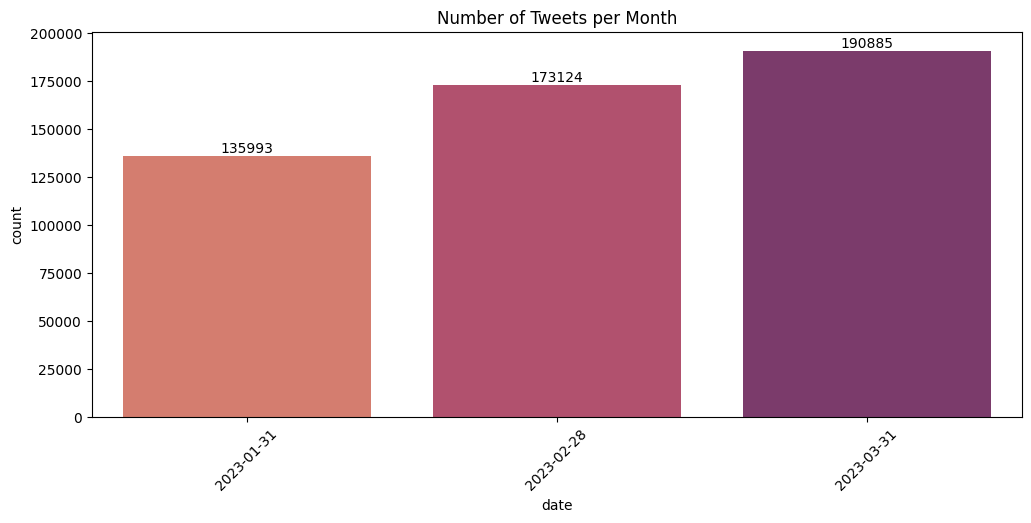

In [31]:
tweets_by_month['date'] = pd.to_datetime(tweets_by_month['date']).dt.date
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(data=tweets_by_month, x='date', y='count', palette='flare')
plt.title('Number of Tweets per Month')
plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i)
plt.show()

In [44]:
hashtags = df_results['content'].str.findall(r'#\w+')
hashtags_count = hashtags.explode().value_counts()
fig_hashtags = px.bar(x=hashtags_count.index[1:16], y=hashtags_count[1:16], title='Top 15 Hashtags',color = hashtags_count[1:16],
                      labels={'x':'Hashtags',
                              'y':'Count'})
fig_hashtags.update_xaxes(tickangle=45)
fig_hashtags.update_layout(width=1200, height=800)
fig_hashtags.show()

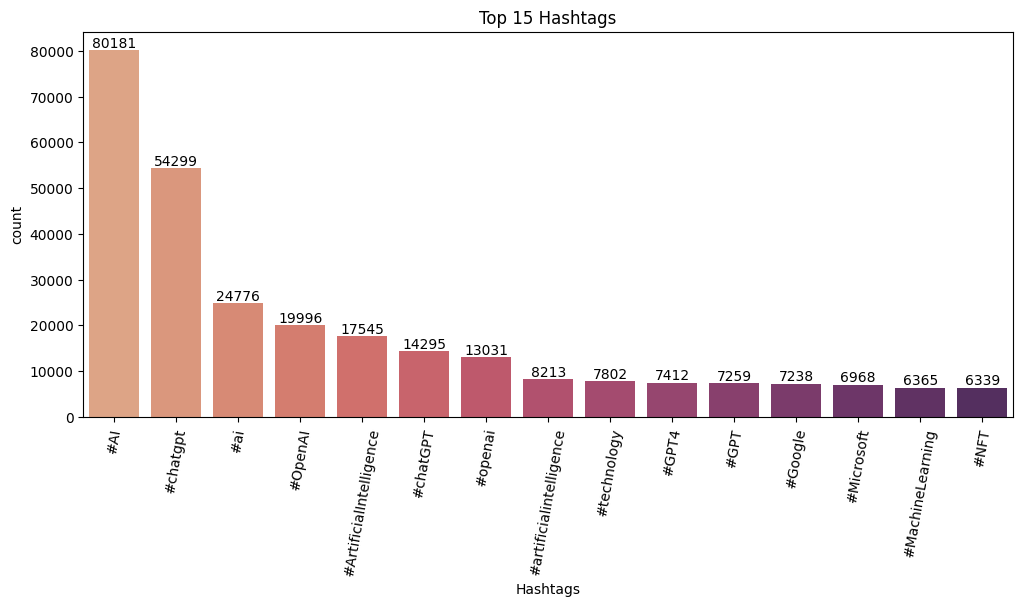

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x=hashtags_count.index[1:16], y=hashtags_count[1:16], palette='flare')
plt.title('Top 15 Hashtags')
plt.xticks(rotation=80)
plt.xlabel('Hashtags')
for i in ax.containers:
    ax.bar_label(i)
plt.show()

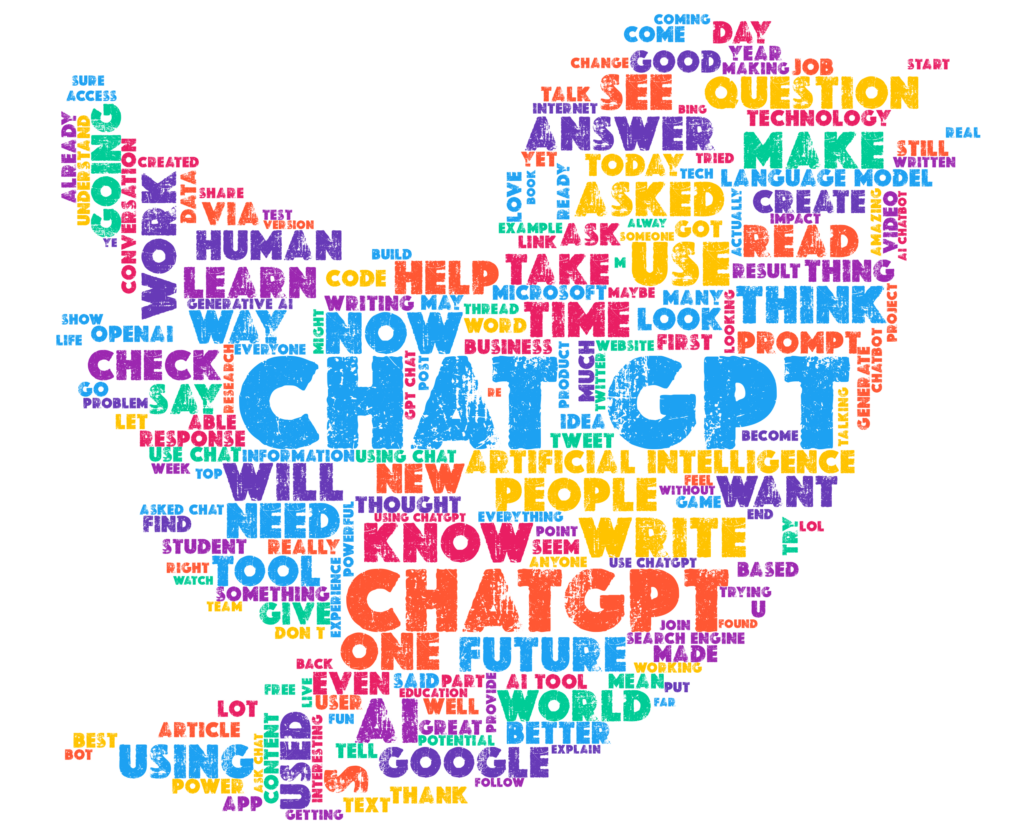

In [21]:
wordnet_lem = WordNetLemmatizer()

df_results['content_lem'] = df_results['processed_content'].apply(wordnet_lem.lemmatize)
all_words_lem = ' '.join([word for word in df_results['content_lem']])


def multi_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1DA1F2', '#00CC96', '#FF5733', '#FFC300', '#E91E63', '#9C27B0', '#673AB7']
    return random.choice(colors)

mask = np.array(Image.open("Wordcloud_content/twitter_logo1.png"))
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000, width=2000,
                              background_color="white", mode="RGBA",
                              stopwords=stopwords, mask=mask, color_func=multi_color_func,
                              font_path='Wordcloud_content/TheGlobePersonalUseBold-2ORlw.ttf').generate(all_words_lem)

plt.figure(figsize=[10, 10])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=multi_color_func), interpolation="bilinear")
plt.savefig("twitter_wordcloud.png", format="png")

plt.show()